In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from functions import *
import time
from torchinfo import summary

In [23]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU()
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d(2)

In [3]:
# 各weight, biasの確認
print(conv1)
print(conv1.weight.shape)
print(conv1.bias.shape)

print('\n--------------\n')

# conv2d
print(conv2)
print(conv2.weight.shape)
print(conv2.bias.shape)


Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])

--------------

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [4]:
# ダミーデータで処理
# 100データ分
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

# CNNのシュミレーション
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [5]:
inputs.max()

tensor(4.6574)

In [6]:
# Transformerの定義

# 1階層
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# 3階層
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [7]:
# データセットの取得
data_root = './hidden_dataset/'

# 一階層セット
#　訓練データ
train_set1 = datasets.CIFAR10(root = data_root,
                              train = True,
                              download = True,
                              transform = transform1)

test_set1 = datasets.CIFAR10(root = data_root,
                              train = False,
                              download = True,
                              transform = transform1)

# ３階層
train_set2 = datasets.CIFAR10(root = data_root,
                              train = True,
                              download = True,
                              transform = transform2)

test_set2 = datasets.CIFAR10(root = data_root,
                              train = False,
                              download = True,
                              transform = transform2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [16]:
# データセットの確認
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [9]:
# データローダの定義
batch_size = 100

# 1階層
train_loader1 = DataLoader(dataset=train_set1,
                           batch_size=batch_size,
                           shuffle=True)

test_loader1 = DataLoader(dataset=test_set1,
                           batch_size=batch_size,
                           shuffle=False)

#　2階層
train_loader2 = DataLoader(dataset=train_set2,
                           batch_size=batch_size,
                           shuffle=True)

test_loader2 = DataLoader(dataset=test_set2,
                           batch_size=batch_size,
                           shuffle=False)

In [15]:
# データローダの確認
for images1, labels1 in train_loader1:
    break

for images2, labels2 in train_loader2:
    break

print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


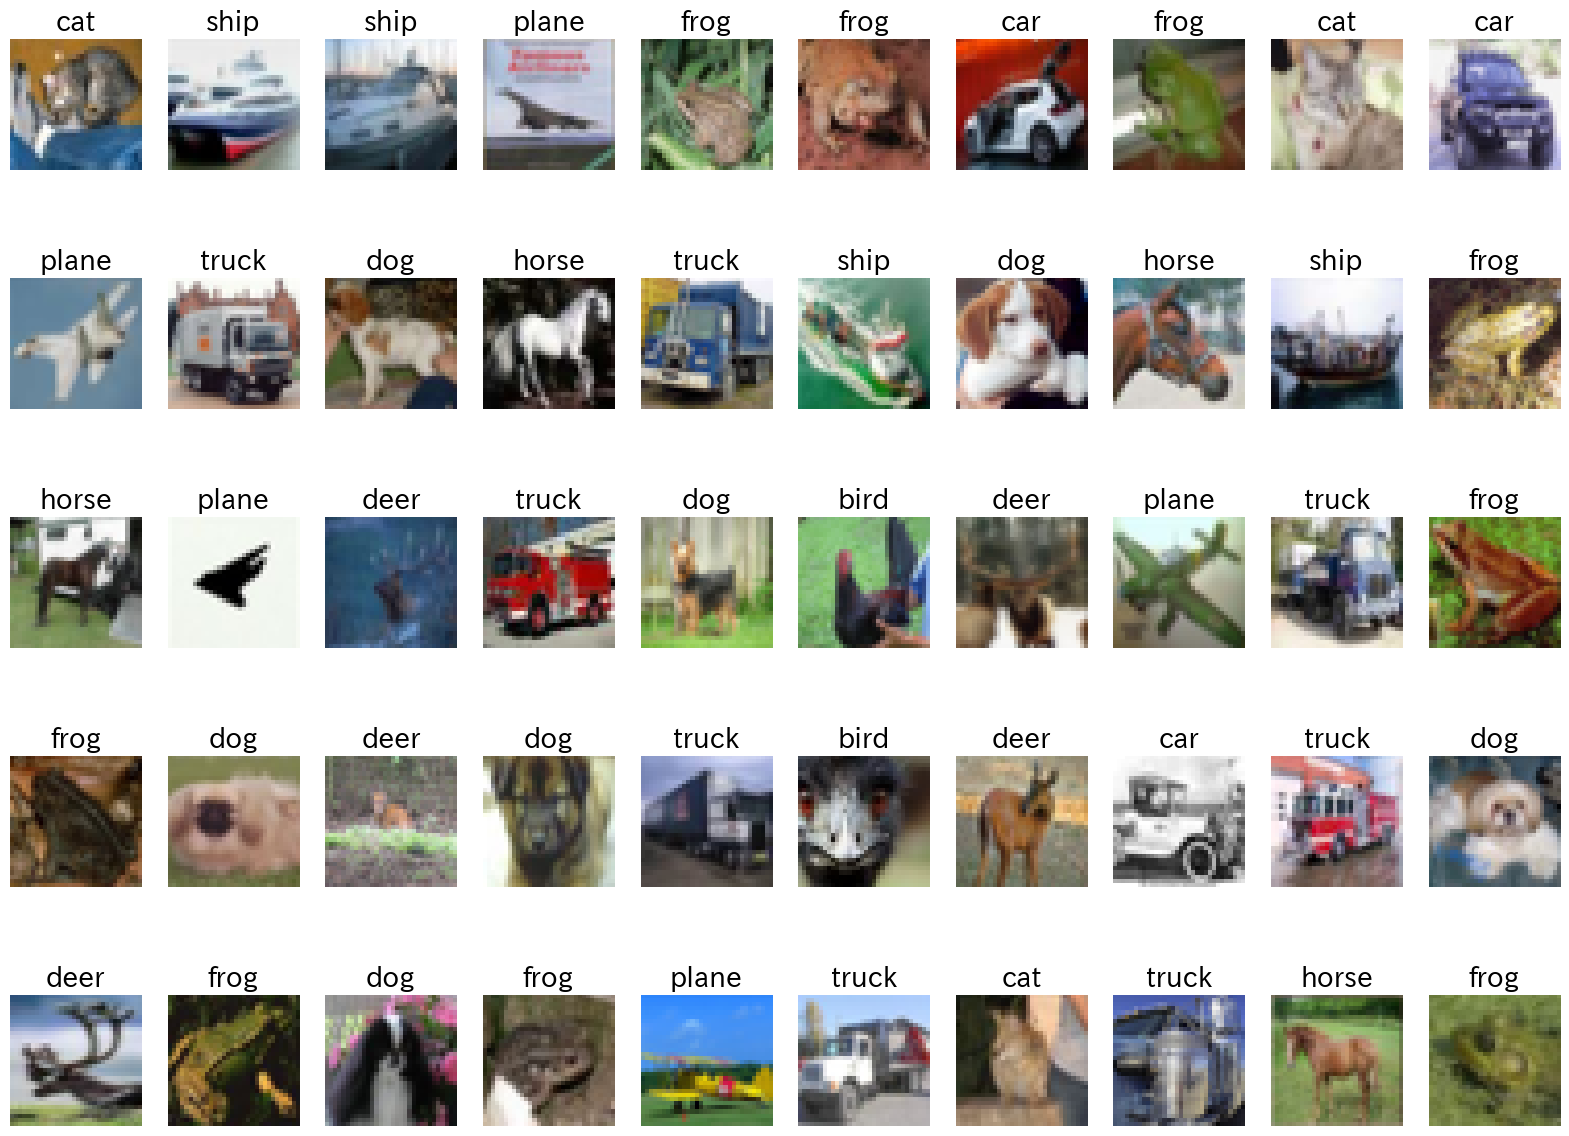

In [11]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

show_images_labels(test_loader2, classes, None, None)

## モデルの定義 (全結合版)

In [21]:
n_input = image1.view(-1).shape[0]

n_output = len(classes)

n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [22]:
# モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [27]:
# 学習

start = time.time()

# 乱数設定
torch.seed()

# netのインスタンス
net = Net(n_input, n_output, n_hidden).to(device)

# 損失
criterion = nn.CrossEntropyLoss()

# 最適化
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr)

# エポック数
num_epoch = 50

# 記録用
history = torch.zeros((0, 5))


history = fit(net, optimizer, criterion, num_epoch, train_loader1, test_loader1, device, history)

end = time.time()

print(f'終了時間: {end - start}' )

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.94500 acc: 0.31994 val_loss: 1.79209, val_acc: 0.37330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73657 acc: 0.39508 val_loss: 1.68491, val_acc: 0.40840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.65422 acc: 0.42510 val_loss: 1.62416, val_acc: 0.43470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.60114 acc: 0.44326 val_loss: 1.58360, val_acc: 0.44750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.56118 acc: 0.45810 val_loss: 1.55447, val_acc: 0.45520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.52907 acc: 0.46874 val_loss: 1.53057, val_acc: 0.46480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.50150 acc: 0.47864 val_loss: 1.51082, val_acc: 0.47110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.47644 acc: 0.48790 val_loss: 1.49413, val_acc: 0.48040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.45404 acc: 0.49600 val_loss: 1.47923, val_acc: 0.48850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.43321 acc: 0.50406 val_loss: 1.46472, val_acc: 0.48910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.41336 acc: 0.51100 val_loss: 1.45136, val_acc: 0.49520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.39427 acc: 0.51902 val_loss: 1.44088, val_acc: 0.49910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.37644 acc: 0.52536 val_loss: 1.42680, val_acc: 0.49920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.35966 acc: 0.53054 val_loss: 1.42180, val_acc: 0.50320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.34353 acc: 0.53734 val_loss: 1.41332, val_acc: 0.50800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.32733 acc: 0.54318 val_loss: 1.40739, val_acc: 0.50740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.31265 acc: 0.54888 val_loss: 1.39605, val_acc: 0.51250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.29812 acc: 0.55450 val_loss: 1.39349, val_acc: 0.51260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.28388 acc: 0.55958 val_loss: 1.38478, val_acc: 0.51610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.27025 acc: 0.56500 val_loss: 1.38050, val_acc: 0.51770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25796 acc: 0.56810 val_loss: 1.37902, val_acc: 0.51400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.24458 acc: 0.57254 val_loss: 1.36942, val_acc: 0.51940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.23274 acc: 0.57788 val_loss: 1.36735, val_acc: 0.51700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.22062 acc: 0.58180 val_loss: 1.36488, val_acc: 0.52390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.20874 acc: 0.58426 val_loss: 1.35880, val_acc: 0.52700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.19801 acc: 0.58878 val_loss: 1.35575, val_acc: 0.52440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.18711 acc: 0.59526 val_loss: 1.35168, val_acc: 0.52680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.17650 acc: 0.59812 val_loss: 1.35265, val_acc: 0.52520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.16581 acc: 0.60142 val_loss: 1.35515, val_acc: 0.52810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.15530 acc: 0.60606 val_loss: 1.36253, val_acc: 0.52330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.14558 acc: 0.60730 val_loss: 1.34791, val_acc: 0.52950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.13541 acc: 0.61362 val_loss: 1.34294, val_acc: 0.53130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.12625 acc: 0.61544 val_loss: 1.35340, val_acc: 0.53110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.11630 acc: 0.62036 val_loss: 1.34911, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.10688 acc: 0.62326 val_loss: 1.34881, val_acc: 0.53200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.09738 acc: 0.62594 val_loss: 1.34733, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.08864 acc: 0.62880 val_loss: 1.34445, val_acc: 0.53240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.07913 acc: 0.63220 val_loss: 1.34760, val_acc: 0.53140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.07100 acc: 0.63672 val_loss: 1.35008, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.06202 acc: 0.63912 val_loss: 1.34191, val_acc: 0.53330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.05411 acc: 0.64296 val_loss: 1.34663, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.04571 acc: 0.64376 val_loss: 1.34693, val_acc: 0.53240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.03715 acc: 0.64876 val_loss: 1.35350, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.02894 acc: 0.65246 val_loss: 1.35110, val_acc: 0.53250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.02198 acc: 0.65394 val_loss: 1.35497, val_acc: 0.53450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.01324 acc: 0.65694 val_loss: 1.35663, val_acc: 0.53160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 1.00565 acc: 0.66156 val_loss: 1.34863, val_acc: 0.53300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.99797 acc: 0.66300 val_loss: 1.35551, val_acc: 0.53490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.98973 acc: 0.66418 val_loss: 1.35449, val_acc: 0.53470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.98176 acc: 0.66786 val_loss: 1.35955, val_acc: 0.53080
終了時間: 1305.7241060733795


初期状態: 損失: 1.79209 精度: 0.37330
最終状態: 損失: 1.35955 精度: 0.53080


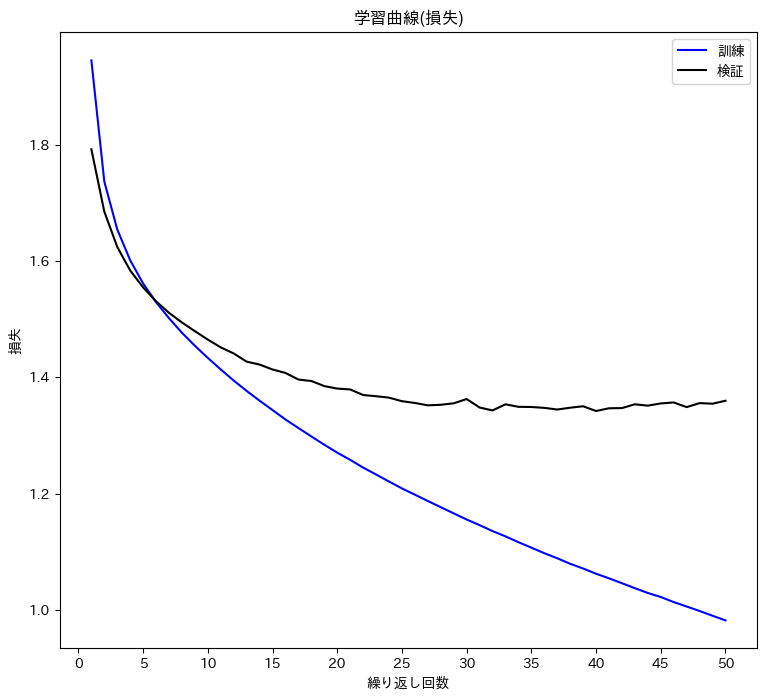

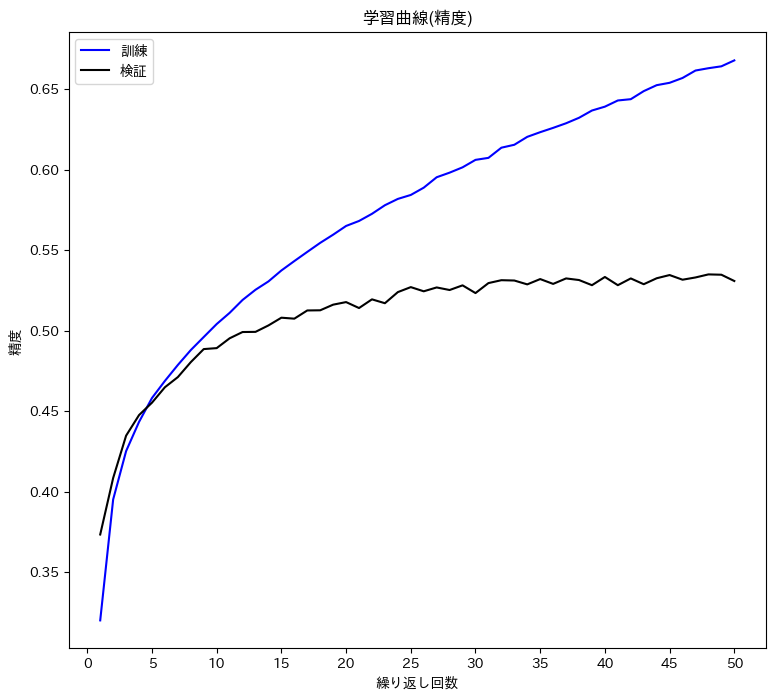

In [28]:
evaluate_history(history)

## CNNモデルの定義

In [70]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1, 
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3       
        

In [87]:

net = CNN(n_output, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr)

In [88]:
# モデルの概要表示
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [92]:
summary(net,(100,3,32,32),depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         9,248
│    └─Conv2d: 2-1                       [100, 32, 30, 30]         896
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [100, 32, 30, 30]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [100, 32, 28, 28]         9,248
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [100, 32, 28, 28]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [100, 32, 14, 14]         --
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [

In [97]:
# cnnの実装
start = time.time()

torch.seed()

net = CNN(n_output, n_hidden)

criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr)

num_epochs = 50

history2 = np.zeros((0, 5))

history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

end = time.time()

print(f'掛かった時間:{end - start}')

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.11568 acc: 0.23748 val_loss: 1.87207, val_acc: 0.34730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.79227 acc: 0.36988 val_loss: 1.70856, val_acc: 0.39990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.63874 acc: 0.42414 val_loss: 1.56987, val_acc: 0.44290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.50812 acc: 0.46490 val_loss: 1.48532, val_acc: 0.46940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.41310 acc: 0.49748 val_loss: 1.38117, val_acc: 0.50180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.33280 acc: 0.52668 val_loss: 1.31015, val_acc: 0.53240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.27102 acc: 0.54854 val_loss: 1.27044, val_acc: 0.54290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.21466 acc: 0.57146 val_loss: 1.21692, val_acc: 0.57170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.16576 acc: 0.59078 val_loss: 1.18690, val_acc: 0.58160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.12381 acc: 0.60716 val_loss: 1.16987, val_acc: 0.58650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.08353 acc: 0.61882 val_loss: 1.14462, val_acc: 0.59590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.04084 acc: 0.63580 val_loss: 1.12375, val_acc: 0.60540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.00239 acc: 0.64822 val_loss: 1.08586, val_acc: 0.61990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.96212 acc: 0.66408 val_loss: 1.06360, val_acc: 0.62010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.92311 acc: 0.67776 val_loss: 1.05037, val_acc: 0.62870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.88408 acc: 0.69242 val_loss: 1.03245, val_acc: 0.63570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.84949 acc: 0.70436 val_loss: 1.02959, val_acc: 0.64020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.81129 acc: 0.71874 val_loss: 1.03122, val_acc: 0.64580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.77806 acc: 0.73114 val_loss: 1.00387, val_acc: 0.64950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.74521 acc: 0.74078 val_loss: 1.04047, val_acc: 0.64070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.71122 acc: 0.75356 val_loss: 1.01399, val_acc: 0.65570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.67806 acc: 0.76454 val_loss: 1.01138, val_acc: 0.65410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.64269 acc: 0.77812 val_loss: 1.01696, val_acc: 0.65680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.61483 acc: 0.78848 val_loss: 1.05937, val_acc: 0.64500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.58027 acc: 0.80100 val_loss: 1.02896, val_acc: 0.66210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.54916 acc: 0.81096 val_loss: 1.02814, val_acc: 0.66600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.51707 acc: 0.82406 val_loss: 1.08752, val_acc: 0.65430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48663 acc: 0.83336 val_loss: 1.13867, val_acc: 0.64270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.45446 acc: 0.84540 val_loss: 1.11630, val_acc: 0.64920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.42427 acc: 0.85616 val_loss: 1.12748, val_acc: 0.65830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.39219 acc: 0.86936 val_loss: 1.14374, val_acc: 0.66220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.36476 acc: 0.87970 val_loss: 1.16802, val_acc: 0.66130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.33725 acc: 0.88816 val_loss: 1.20881, val_acc: 0.65620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.30773 acc: 0.89960 val_loss: 1.21891, val_acc: 0.65450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.28574 acc: 0.90698 val_loss: 1.27166, val_acc: 0.65310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.25164 acc: 0.92042 val_loss: 1.34240, val_acc: 0.64920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.22840 acc: 0.92870 val_loss: 1.32977, val_acc: 0.65840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.20481 acc: 0.93644 val_loss: 1.39856, val_acc: 0.64890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.18325 acc: 0.94630 val_loss: 1.44462, val_acc: 0.65080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.15383 acc: 0.95652 val_loss: 1.62044, val_acc: 0.63470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.13611 acc: 0.96260 val_loss: 1.57696, val_acc: 0.65400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.12040 acc: 0.96858 val_loss: 1.57499, val_acc: 0.65080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.09356 acc: 0.97868 val_loss: 1.67304, val_acc: 0.64890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.07872 acc: 0.98350 val_loss: 1.72135, val_acc: 0.64830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.07014 acc: 0.98546 val_loss: 1.76196, val_acc: 0.64940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.05236 acc: 0.99238 val_loss: 1.82296, val_acc: 0.64680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.03904 acc: 0.99566 val_loss: 1.90444, val_acc: 0.64660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03233 acc: 0.99706 val_loss: 1.91042, val_acc: 0.65300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02419 acc: 0.99874 val_loss: 1.96437, val_acc: 0.65190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.01936 acc: 0.99926 val_loss: 1.99680, val_acc: 0.65660
掛かった時間:2763.5931901931763


GPU(T4)では -> 掛かった時間:921.6939368247986

初期状態: 損失: 1.87207 精度: 0.34730
最終状態: 損失: 1.99680 精度: 0.65660


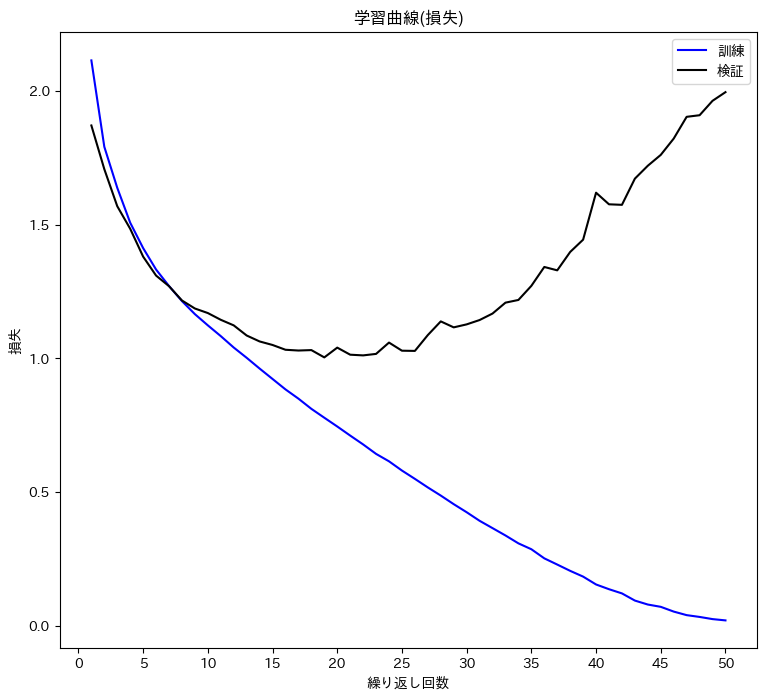

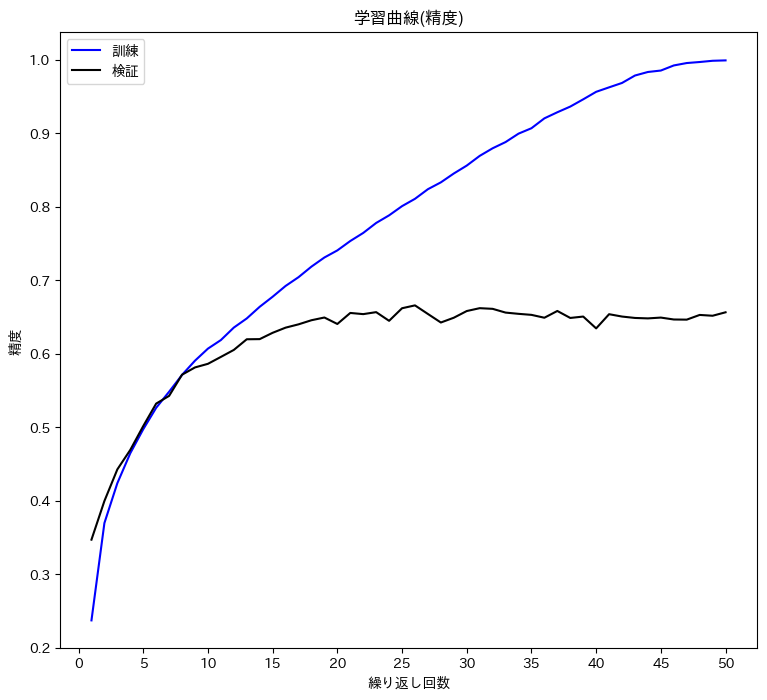

In [98]:
evaluate_history(history2)

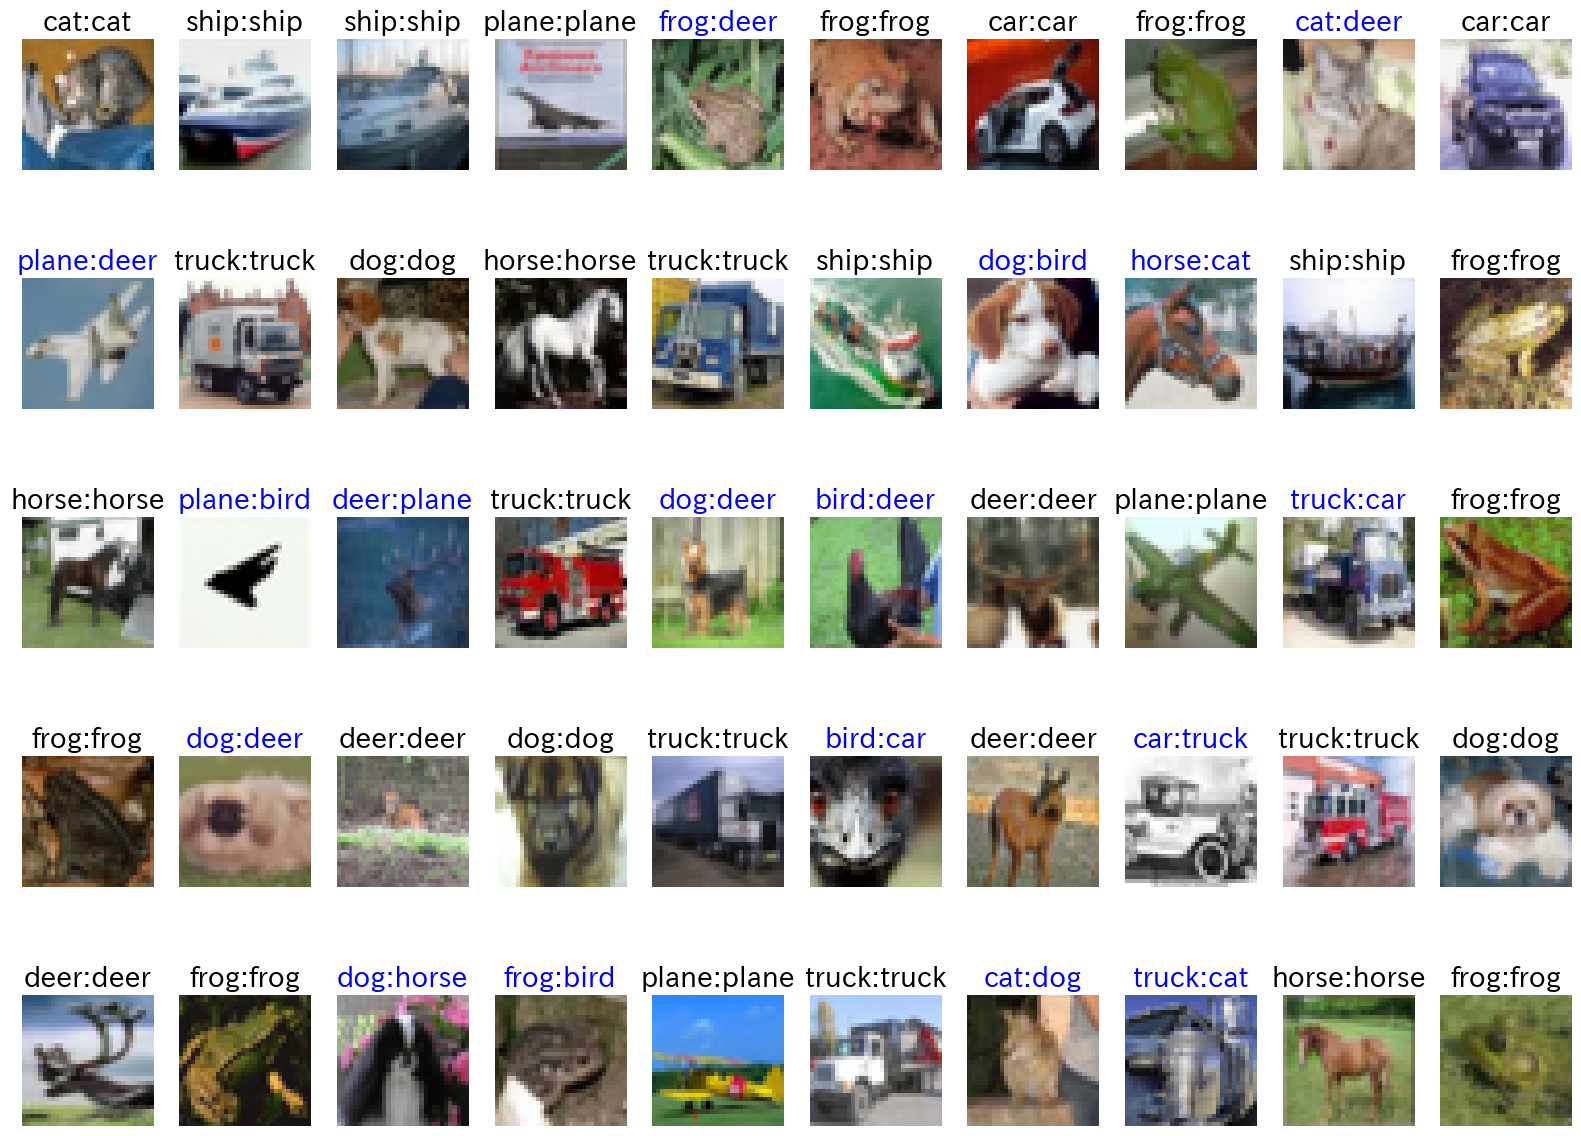

In [99]:
show_images_labels(test_loader2, classes, net, device)